In [2]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np

# Setting up fake observations

In [3]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

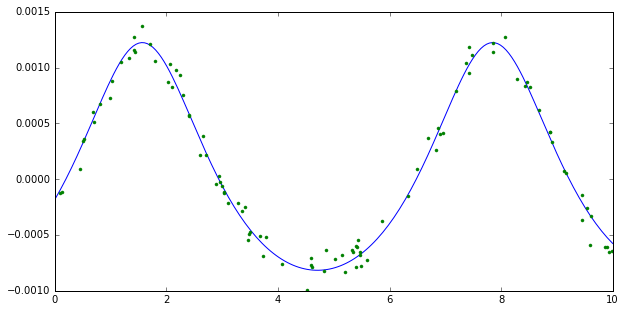

In [4]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=10.))
ax.plot(obs.t, obs.rv, ".")

# SMALA 
Starting from exact solution.

In [8]:
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.}], ignore_vars=["a","m"])
smala = mcmc.Smala(s,obs)
Niter = 1000
chain = np.zeros((Niter,s.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
for i in range(Niter):
    tries += smala.step_force()
    chain[i] = smala.state.get_params()
    chainlogp[i] = smala.state.logp
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 90.50%


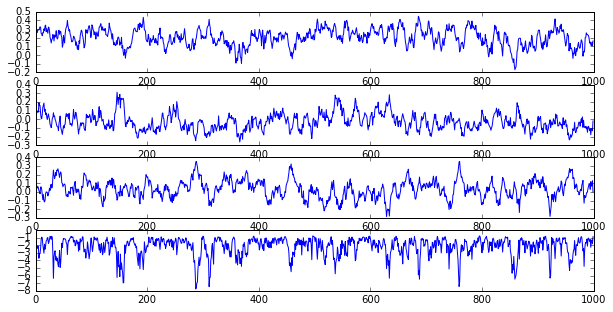

In [9]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars+1,1,1+i)
    ax.plot(chain[:,i])
ax = plt.subplot(s.Nvars+1,1,s.Nvars+1)
ax.plot(chainlogp)    

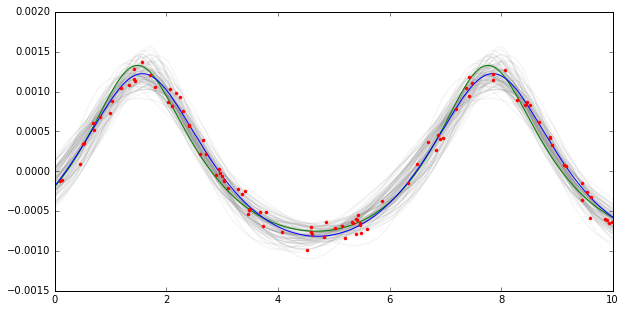

In [10]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = smala.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
s = smala.state.deepcopy()
s.set_params(chain[0])
ax.plot(*s.get_rv_plotting(tmax=10.), color="green")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

# Metropolis Hastings
Starting from a very wrong initial set of parameters.

In [11]:
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":-0.3, "k":0.1, "l":1.4}], ignore_vars=["a","m"])
mh = mcmc.Mh(s,obs)
mh.scales = 5e-2*np.ones(s.Nvars)
Niter = 1000
chain = np.zeros((Niter,s.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
for i in range(Niter):
    tries += mh.step_force()
    chain[i] = mh.state.get_params()
    chainlogp[i] = mh.state.logp
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 66.93%


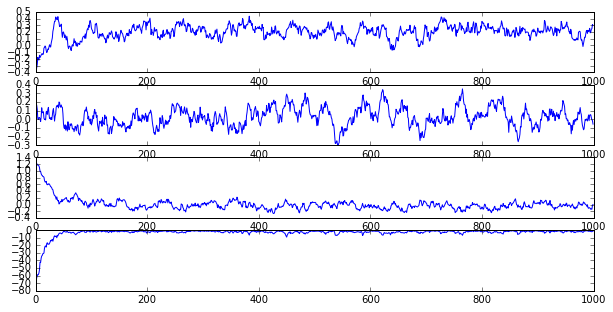

In [12]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars+1,1,1+i)
    ax.plot(chain[:,i])
ax = plt.subplot(s.Nvars+1,1,s.Nvars+1)
ax.plot(chainlogp)    

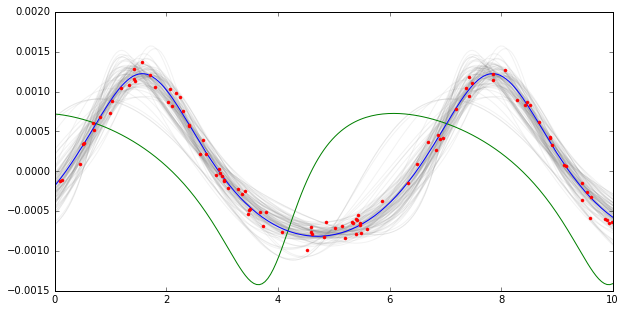

In [13]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = mh.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
s = mh.state.deepcopy()
s.set_params(chain[0])
ax.plot(*s.get_rv_plotting(tmax=10.), color="green")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

# Derivative tests
Compares result from finite differences to variational equations.

In [14]:
Delta = 1e-4
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0., "l":1.4}], ignore_vars=["a","m"])
chi2 = s.get_chi2(obs)
fd_d = np.zeros(s.Nvars)
fd_dd = np.zeros((s.Nvars,s.Nvars))
for i in range(s.Nvars):
    shift = np.zeros(s.Nvars)
    shift[i] = Delta
    s.shift_params(shift);
    chi2p = s.get_chi2(obs)
    s.shift_params(-shift);
    fd_d[i] = (chi2p-chi2)/Delta
    for j in range(s.Nvars):
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] += Delta
        s.shift_params(shift);
        chi2pp = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] += Delta
        s.shift_params(shift);
        chi2mp = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] -= Delta
        s.shift_params(shift);
        chi2pm = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] -= Delta
        s.shift_params(shift);
        chi2mm = s.get_chi2(obs)
        s.shift_params(-shift);
        
        fd_dd[i][j] = (chi2pp-chi2mp-chi2pm+chi2mm)/(4.*Delta**2)

chi2, v_d, v_dd = s.get_chi2_d_dd(obs)

print("First order:")
print(fd_d)
print(v_d)
print("\nSecond order:")
print(fd_dd)
print(v_dd)

First order:
[ -1.75160005 -34.42159877  83.0840604 ]
[ -1.75086618 -34.4238031   83.08319631]

Second order:
[[ -14.68183974 -113.797838   -103.05218758]
 [-113.797838     44.06990612    3.85218897]
 [-103.05218758    3.85218897   17.28137882]]
[[ -14.68182376 -113.79783703 -103.05219765]
 [-113.79783703   44.06991947    3.85219944]
 [-103.05219765    3.85219944   17.28139177]]
